In [1]:
import os
import mne
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat
from mne.preprocessing import ICA
from mne.channels import make_standard_montage
from mne.io import RawArray

In [3]:
# Parameters for band-pass filter
low_freq= 0
high_freq= 40
transition_bw = 2
filter_type = 'fir'
window = 'blackman'

# Parameters for epoching
tmin = 0
tmax = 0.85

In [4]:
folder_name = 'Dataset Motor Imagery'
cur_wdir = os.getcwd()
data_dir = os.path.join(cur_wdir, folder_name)
file_list = os.listdir(data_dir)
file_list

['5F-SubjectA-160405-5St-SGLHand.mat',
 '5F-SubjectA-160408-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-151110-5St-SGLHand.mat',
 '5F-SubjectB-160309-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160311-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160316-5St-SGLHand.mat',
 '5F-SubjectC-151204-5St-SGLHand.mat',
 '5F-SubjectC-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160321-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160415-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectF-151027-5St-SGLHand.mat',
 '5F-SubjectF-160209-5St-SGLHand.mat',
 '5F-SubjectF-160210-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160413-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160428-5St-SGLHand-HFREQ.mat',
 '5F-SubjectH-160804-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160719-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160723-5St-SGLHand-HFREQ.mat']

In [5]:
# Isolate files with 'HFREQ' in the name
lfreq_list = [filename for filename in file_list if 'HFREQ' not in filename]
lfreq_list

['5F-SubjectA-160405-5St-SGLHand.mat',
 '5F-SubjectB-151110-5St-SGLHand.mat',
 '5F-SubjectB-160316-5St-SGLHand.mat',
 '5F-SubjectC-151204-5St-SGLHand.mat',
 '5F-SubjectF-151027-5St-SGLHand.mat',
 '5F-SubjectF-160209-5St-SGLHand.mat']

In [6]:
df = pd.DataFrame()
for file in lfreq_list:
    loaded_file = loadmat(os.path.join(data_dir, file))
    df = df.append(loaded_file, ignore_index = True)
df

,__globals__,__header__,__version__,o
0,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201604051923.D091BB44'], ['NK-data import..."
1,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201511101935.2DE0AC81'], ['NK-data import..."
2,[],"b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...",1.0,"[[[['201603161935.D091BB44'], ['NK-data import..."
3,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201512041924.951FEF1D'], ['NK-data import..."
4,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201510271827.D091BB44'], ['NK-data import..."
5,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201602091352.D091BB44'], ['NK-data import..."


In [7]:
# Get EEG data from file
eeg_datas = df["o"]

In [8]:
channels = [eeg_datas[0]['chnames'][0][0][i][0][0] for i in range(len(eeg_datas[0]['chnames'][0][0]))]
ch_types = ['eeg'] * 21 + ['misc']
sfreq = eeg_datas[0]['sampFreq'][0][0][0][0]

In [9]:
# Create a list of the data in mne object
dataset = []
for index in list(eeg_datas.index):
    info_eeg = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
    data = eeg_datas[index]['data'][0][0].T
    eeg_data = RawArray(data, info_eeg)
    dataset.append(eeg_data)

Creating RawArray with float64 data, n_channels=22, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=724600
    Range : 0 ... 724599 =      0.000 ...  3622.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=718800
    Range : 0 ... 718799 =      0.000 ...  3593.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=722200
    Range : 0 ... 722199 =      0.000 ...  3610.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=736600
    Range : 0 ... 736599 =      0.000 ...  3682.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=718400
    Range : 0 ... 718399 =      0.000 ...  3591.995 secs
Ready.


In [10]:
# Create montage
for index in list(eeg_datas.index):
    montage = make_standard_montage('standard_1020')
    dataset[index].set_montage(montage)

In [11]:
# Add marker to the dataset list
for index in list(eeg_datas.index):
    marker_data = eeg_datas[index]['marker'][0][0].T
    info_marker = mne.create_info(['STI'], dataset[index].info['sfreq'], ['stim'])
    markers = RawArray(marker_data, info_marker)
    dataset[index].add_channels([markers], force_update_info = True)

Creating RawArray with float64 data, n_channels=1, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=724600
    Range : 0 ... 724599 =      0.000 ...  3622.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=718800
    Range : 0 ... 718799 =      0.000 ...  3593.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=722200
    Range : 0 ... 722199 =      0.000 ...  3610.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=736600
    Range : 0 ... 736599 =      0.000 ...  3682.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=718400
    Range : 0 ... 718399 =      0.000 ...  3591.995 secs
Ready.


In [12]:
events = []
for index in list(eeg_datas.index):
    event = mne.find_events(dataset[index], stim_channel = 'STI')
    events.append(event)

967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
958 events found
Event IDs: [1 2 3 4 5]
967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
958 events found
Event IDs: [1 2 3 4 5]
957 events found
Event IDs: [1 2 3 4 5]
958 events found
Event IDs: [1 2 3 4 5]


In [13]:
# Record events in a dictionary
event_dict = {'thumb': 1, 'index': 2, 'middle': 3, 'ring': 4, 'pinky': 5}

## Data Visualization

Creating RawArray with float64 data, n_channels=21, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


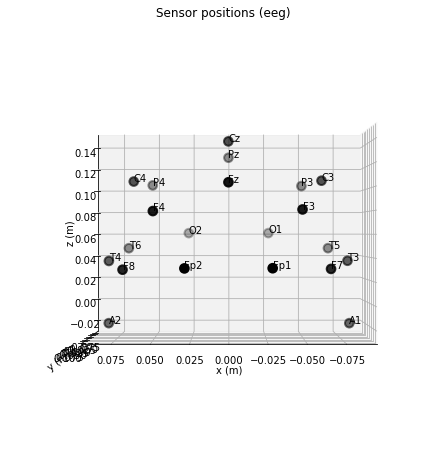

Creating RawArray with float64 data, n_channels=21, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


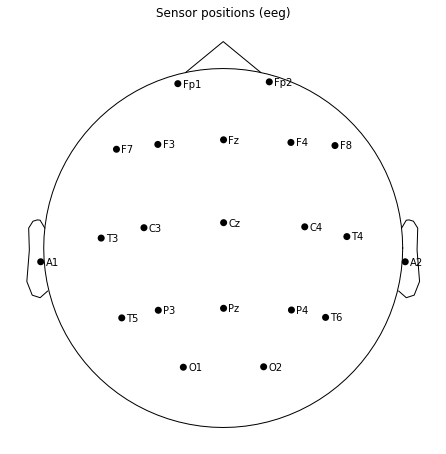

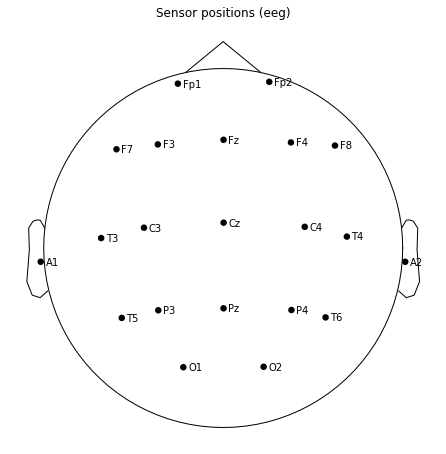

In [14]:
# Check dataset montage configuration plot
montage_check = dataset[0].get_montage()

fig = montage_check.plot(kind = '3d')
fig.gca().view_init(azim = 70, elev = 15)
montage_check.plot(kind = 'topomap', show_names = True)

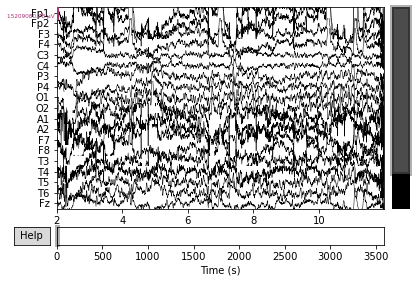

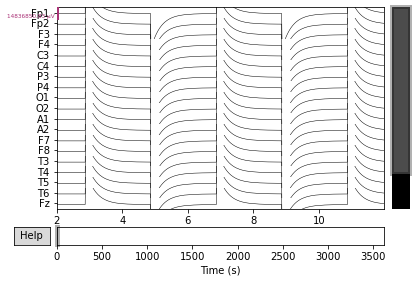

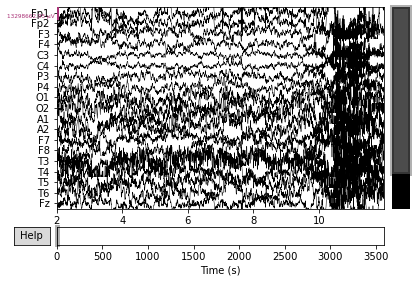

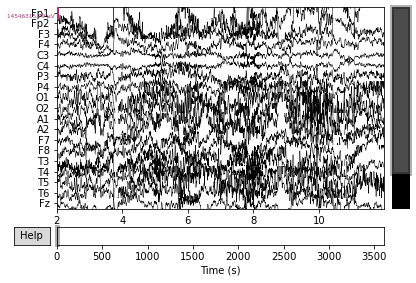

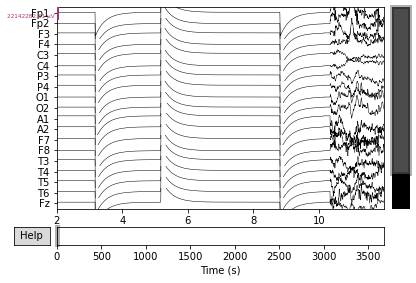

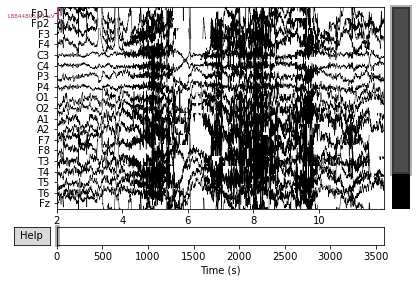

In [15]:
# Plot the raw EEG data
for index in list(eeg_datas.index):
    mne.viz.plot_raw(dataset[index], events = events[index], start = 2, n_channels = 19, title = lfreq_list[index],
                     event_color = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 99: 'k'}, scalings = 'auto')

<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)
<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)
<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)


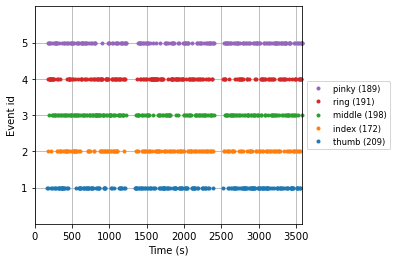

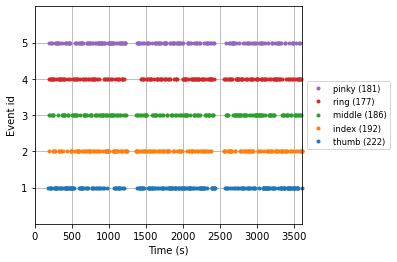

<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)
<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)
<ipython-input-16-34bcb16b6fe4>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)


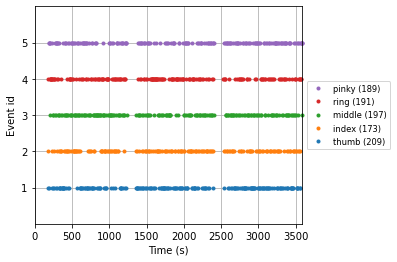

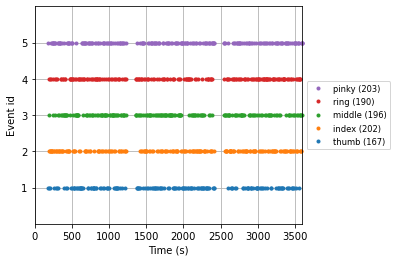

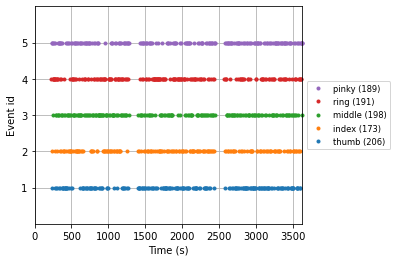

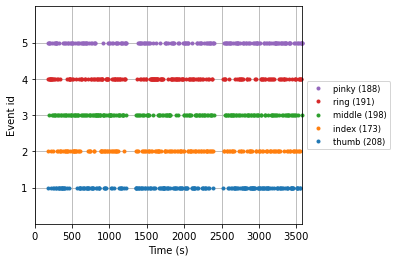

In [16]:
# Plotting event marker to check marker quantity 
for index in list(eeg_datas.index):
    fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id =event_dict)

Effective window size : 10.240 (s)


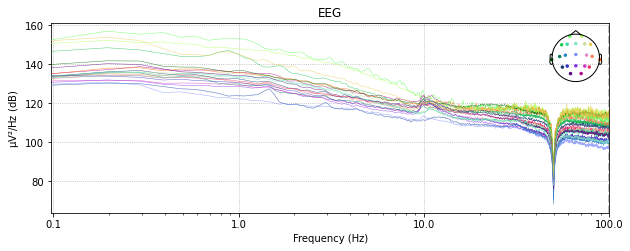

Effective window size : 10.240 (s)


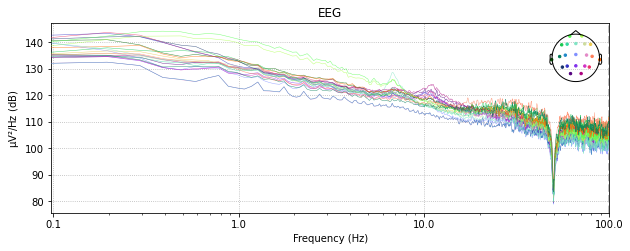

Effective window size : 10.240 (s)


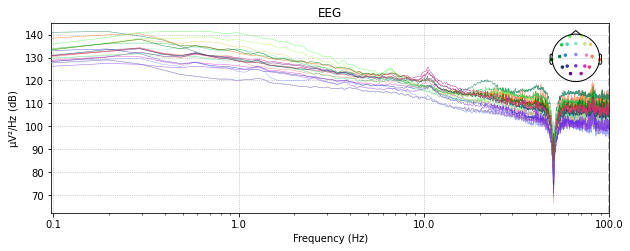

Effective window size : 10.240 (s)


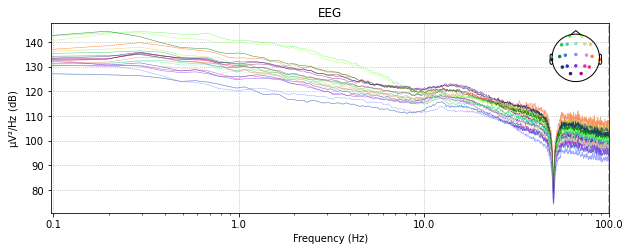

Effective window size : 10.240 (s)


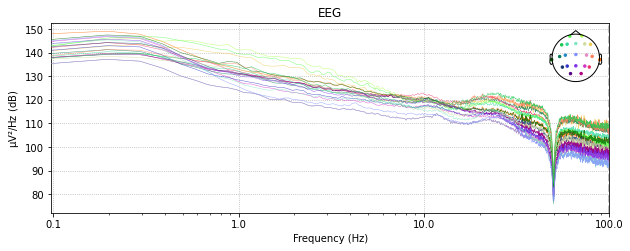

Effective window size : 10.240 (s)


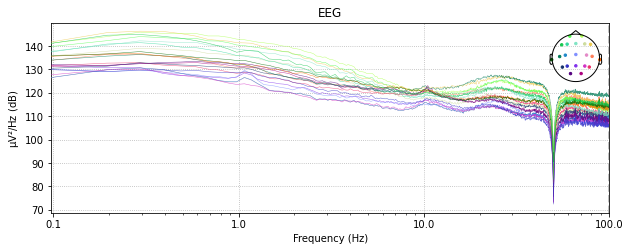

In [17]:
# PSD of EEG signal
for index in list(eeg_datas.index):
    mne.viz.plot_raw_psd(dataset[index], fmax = np.inf, reject_by_annotation = False, xscale = 'log')

dari plot PSD data raw tersebut dapat dilihat bahwa telah dilakukan notch filter pada 50 Hz dataset tersebut

gamber diatas merupakan plot psd pada rentang frekuensi 10-40 Hz, yaitu rentang frekuensi terjadinya ERD/ERS ritme alpha, beta, dan gama selama proses MI jari tangan

Effective window size : 10.005 (s)


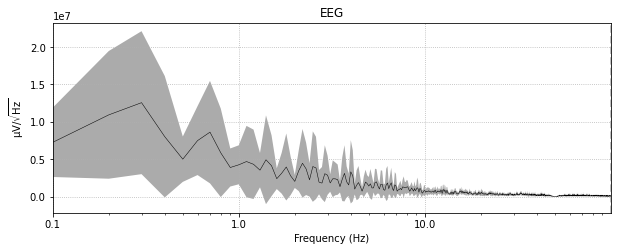

Effective window size : 10.005 (s)


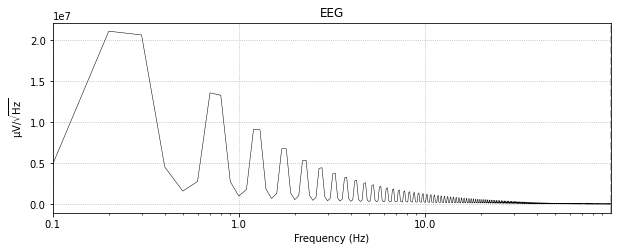

Effective window size : 10.005 (s)


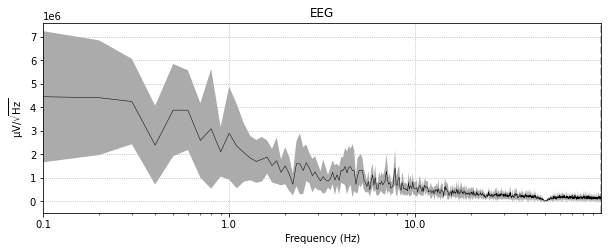

Effective window size : 10.005 (s)


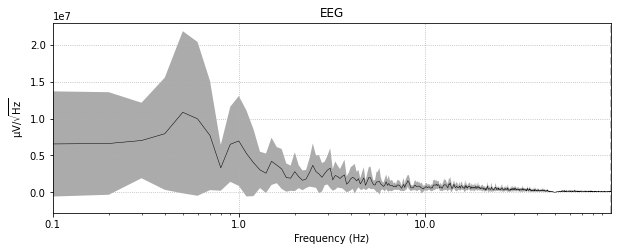

Effective window size : 10.005 (s)


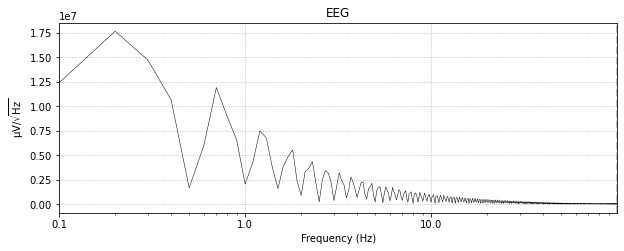

Effective window size : 10.005 (s)


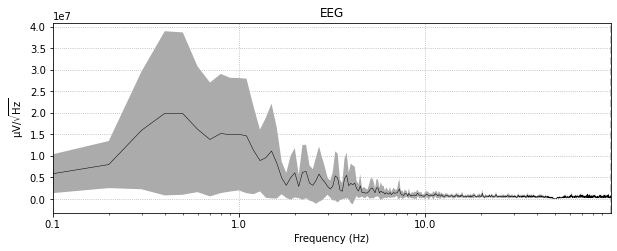

In [18]:
# Amplitude Spectral Density
for index in list(eeg_datas.index):
    dataset[index].plot_psd(tmax=10., average = True, spatial_colors = True, dB = False, xscale = 'log')

## Filtering

In [14]:
#bandpass filtering to get signal of interest
##create bandpass filter parameter
#visualsisasi parameter filter
filter_params = mne.filter.create_filter(dataset[0].get_data(), dataset[0].info['sfreq'], l_freq = low_freq,
                                         h_freq = high_freq, method = filter_type, fir_window = window,
                                         h_trans_bandwidth = transition_bw)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)



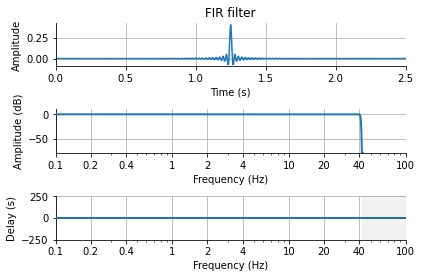

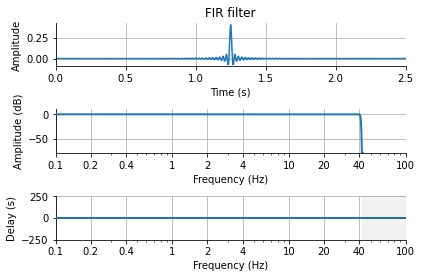

In [20]:
mne.viz.plot_filter(filter_params, dataset[0].info['sfreq'])

In [15]:
#filtering the signal
#masih rentang 8-40 hz
for index in list(eeg_datas.index):
    dataset[index].filter(l_freq = low_freq, h_freq = high_freq, picks = None, filter_length = 'auto',
                          l_trans_bandwidth = 'auto', h_trans_bandwidth = transition_bw, 
                          method = filter_type, fir_window = window)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter

Effective window size : 10.240 (s)


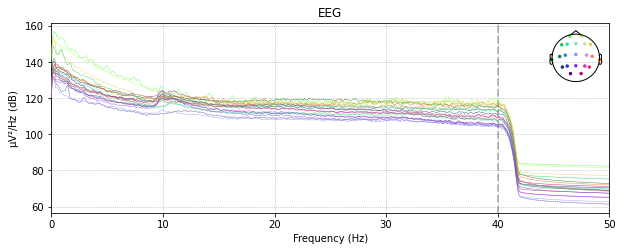

Effective window size : 10.240 (s)


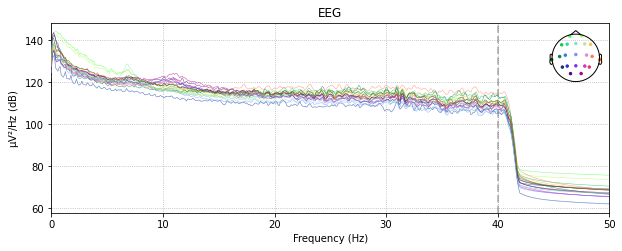

Effective window size : 10.240 (s)


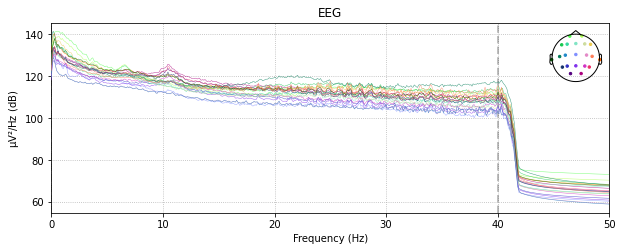

Effective window size : 10.240 (s)


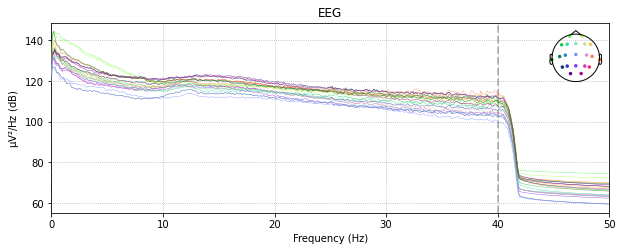

Effective window size : 10.240 (s)


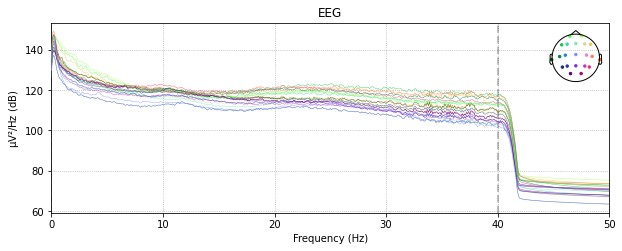

Effective window size : 10.240 (s)


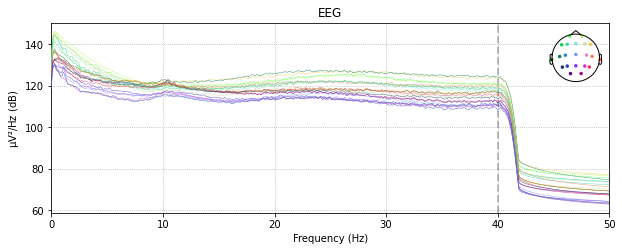

In [22]:
#plot psd of filtered signal
for index in list(eeg_datas.index):
    mne.viz.plot_raw_psd(dataset[index], fmax = 50, reject_by_annotation = False, xscale = 'linear')

Effective window size : 10.005 (s)


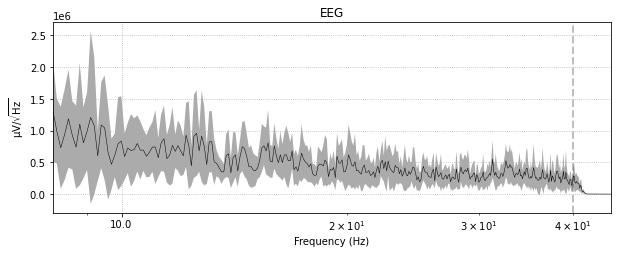

Effective window size : 10.005 (s)


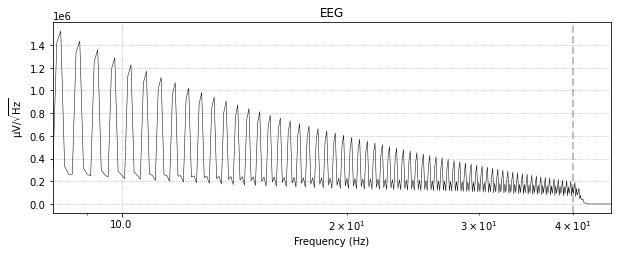

Effective window size : 10.005 (s)


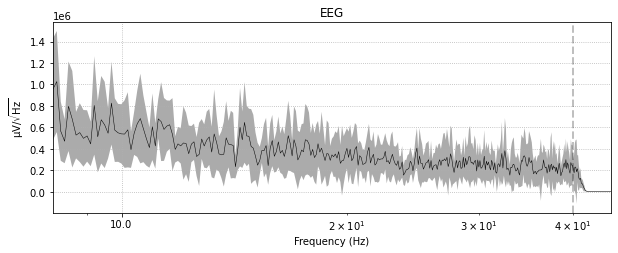

Effective window size : 10.005 (s)


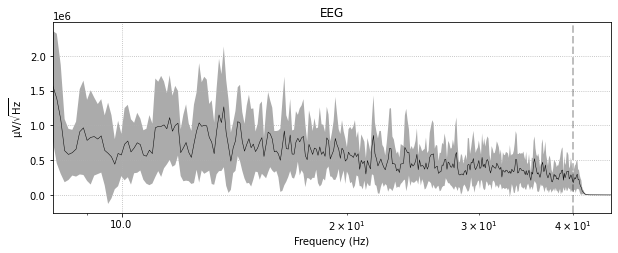

Effective window size : 10.005 (s)


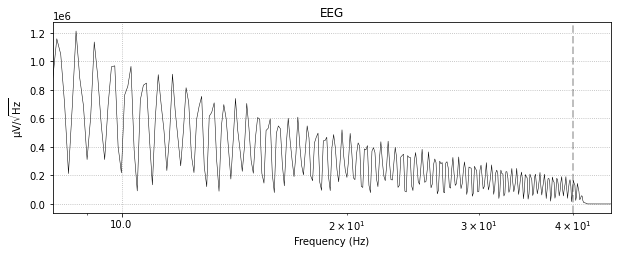

Effective window size : 10.005 (s)


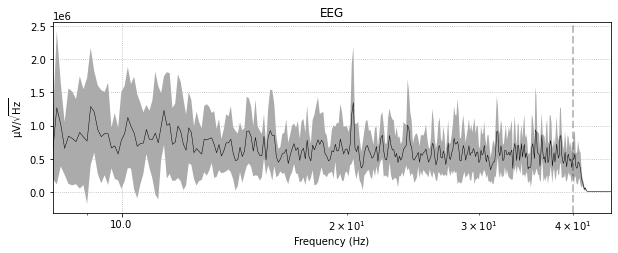

In [23]:
#signal PSD Variance
for index in list(eeg_datas.index):
    dataset[index].plot_psd(tmax = 10., fmin = 8, fmax = 45, average = True, spatial_colors = True,
                            dB = False, xscale = 'log')

Rentang frekuensi yang diambil adalah 10-40Hz, rentang tersebut mengandung alpha ERD, beta ERS, dan gamma oscilation selama dan setelah MI jari tangan

## Epoching & Downsampling

In [16]:
# Epoching raw EEG
epochs = []
for index in list(eeg_datas.index): 
    dataset[index].drop_channels(['X5', 'STI'])
    epoch = mne.Epochs(dataset[index], events = events[index], tmin = tmin, tmax = tmax, 
                       event_id = event_dict, preload = True, baseline = None)
    epochs.append(epoch)

Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Loading data for 957 events and 

In [17]:
for index in range(len(lfreq_list)):
    print(lfreq_list[index])
    print(epochs[index])

5F-SubjectA-160405-5St-SGLHand.mat
<Epochs |  959 events (all good), 0 - 0.85 sec, baseline off, ~26.3 MB, data loaded,
 'index': 172
 'middle': 198
 'pinky': 189
 'ring': 191
 'thumb': 209>
5F-SubjectB-151110-5St-SGLHand.mat
<Epochs |  958 events (all good), 0 - 0.85 sec, baseline off, ~26.3 MB, data loaded,
 'index': 192
 'middle': 186
 'pinky': 181
 'ring': 177
 'thumb': 222>
5F-SubjectB-160316-5St-SGLHand.mat
<Epochs |  959 events (all good), 0 - 0.85 sec, baseline off, ~26.3 MB, data loaded,
 'index': 173
 'middle': 197
 'pinky': 189
 'ring': 191
 'thumb': 209>
5F-SubjectC-151204-5St-SGLHand.mat
<Epochs |  958 events (all good), 0 - 0.85 sec, baseline off, ~26.3 MB, data loaded,
 'index': 202
 'middle': 196
 'pinky': 203
 'ring': 190
 'thumb': 167>
5F-SubjectF-151027-5St-SGLHand.mat
<Epochs |  957 events (all good), 0 - 0.85 sec, baseline off, ~26.3 MB, data loaded,
 'index': 173
 'middle': 198
 'pinky': 189
 'ring': 191
 'thumb': 206>
5F-SubjectF-160209-5St-SGLHand.mat
<Epochs | 

epoch yang diambil dari t= -2 sekon hingga t=0.75s sesuai dengan rentang waktu terjadinya ERS/ERD.  Tapi di Kaya dkk, dari 0-0.85

In [25]:
for index in list(eeg_datas.index):
    print(epochs[index].info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG


Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


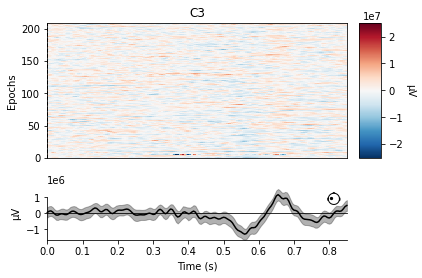

Not setting metadata
Not setting metadata
222 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


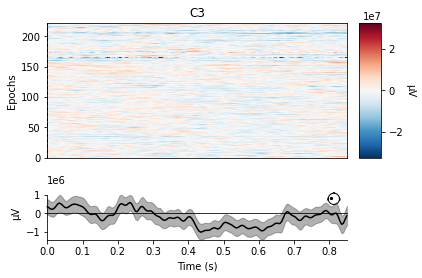

Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


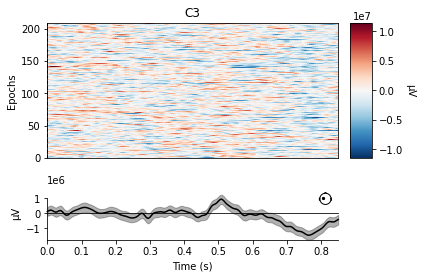

Not setting metadata
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


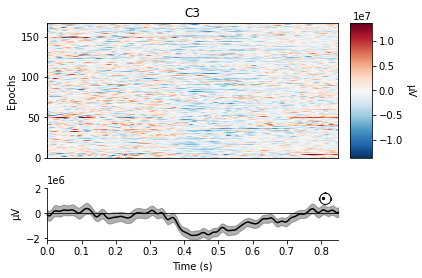

Not setting metadata
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


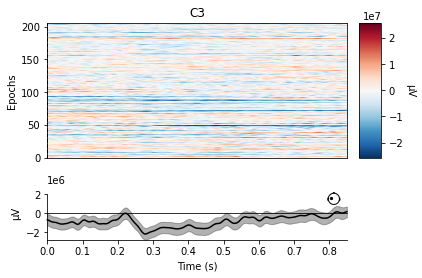

Not setting metadata
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


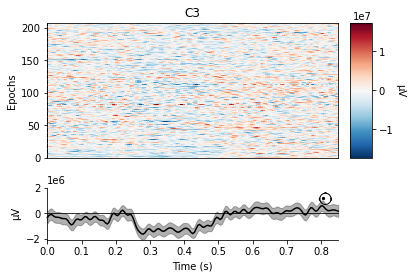

In [26]:
#plot rata-rata epoch 'thumb' pada kanal c3
for index in list(eeg_datas.index): 
    epochs[index]['thumb'].plot_image(picks = 'C3')

#Visualizing Evoked data

input csp merupakan epoch. data sinyal evoked hanya untuk konfirmasi plotting rata2 sinyal antar kanal per event nya

No projector specified for this dataset. Please consider the method self.add_proj.


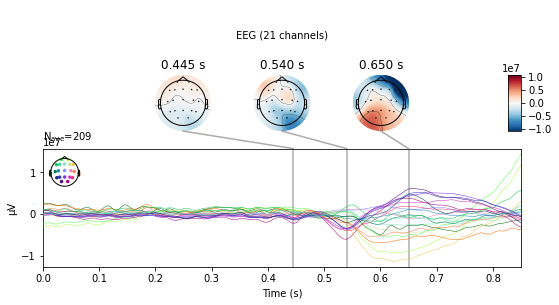

No projector specified for this dataset. Please consider the method self.add_proj.


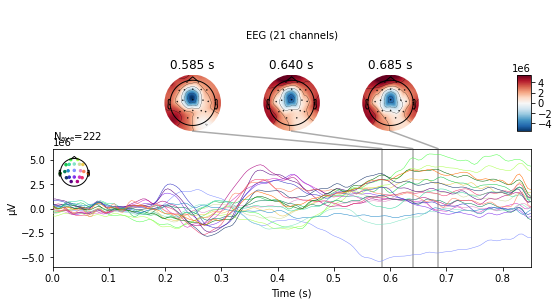

No projector specified for this dataset. Please consider the method self.add_proj.


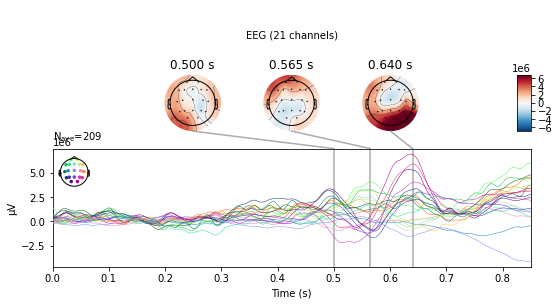

No projector specified for this dataset. Please consider the method self.add_proj.


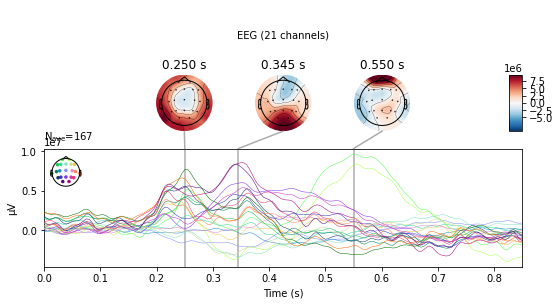

No projector specified for this dataset. Please consider the method self.add_proj.


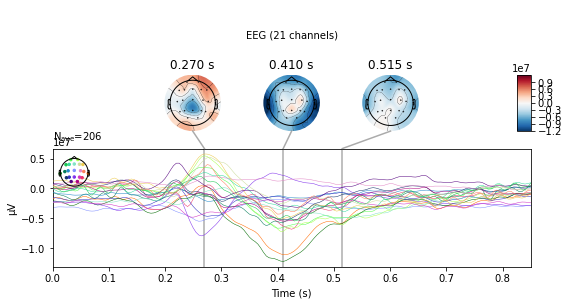

No projector specified for this dataset. Please consider the method self.add_proj.


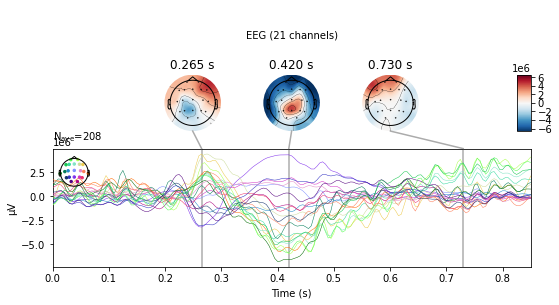

In [27]:
evoked_eeg =[]
for index in list(eeg_datas.index): 
    evoked = epochs[index]['thumb'].average()
    evoked.plot_joint()
    evoked_eeg.append(evoked)

In [28]:
save_folder = 'Preprocessed Data MI'
epoch_folder = 'Epoch'
save_epoch_path = os.path.join(cur_wdir, save_folder, epoch_folder)
if not os.path.isdir(save_epoch_path):
    os.mkdir(save_epoch_path)

In [29]:
event_folder = 'Event'
save_event_path = os.path.join(cur_wdir, save_folder, event_folder)
if not os.path.isdir(save_event_path):
    os.mkdir(save_event_path)

In [30]:
for index, filename in enumerate(lfreq_list):
    parsed_name = filename.split('-')
    new_filename = parsed_name[1] + '-' + parsed_name[2] + '-epo.fif'
    epochs[index].save(os.path.join(save_epoch_path, new_filename), overwrite = True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [31]:
for index, filename in enumerate(lfreq_list):
    parsed_name = filename.split('-')
    new_filename = parsed_name[1] + '-' + parsed_name[2] + '-eve.fif'
    mne.write_events(os.path.join(save_event_path, new_filename), events[index])

In [32]:
# # In case you want to remove files, uncomment this block
# for fif_file in os.listdir(save_event_path):
#     if '-eve.fif' not in fif_file:
#         os.remove(os.path.join(save_dir, fif_file))